# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Mentoría 16 - ¿Cómo identificar fuga de ventas? Inteligencia artificial aplicada al sector comercial.

### Explorando Patrones de Datos a través de Clustering (TP3)

#### Parte 3: Clusterización con K-means y DBSCAN.

**Integrantes:**
- Canalis, Patricio.
- Chevallier-Boutell, Ignacio José.
- Villarroel Torrez, Daniel.

**Mentores:**
- Gonzalez, Lucía
- Lahoz, Nahuel

---
## Librerías y dataset

In [1]:
# Visualización y curación
import pandas as pd
import seaborn as sns

# Clustering
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# Funciones propias
from tp3_utils_cluster import *
%load_ext autoreload
%autoreload 2

# Preferencias
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows',150)
sns.set_context('talk')
sns.set_theme(style='white')

Partimos del dataset ya curado y pivoteado, el cual:
* Contiene 10 subrubros.
* Fue imputado utilizando KNN con $k=5$.
* Se reescaleo utilizando `MinMaxScaler`, el cual mapea cada característica al rango $[0,1]$.
* Aplicamos PCA para reducir a las 12 componentes principales.

In [2]:
sr10_knn_pca = pd.read_csv('../data/interim/tp3_sr10_knn5_pca12.csv')

In [3]:
sr10_knn_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3135 entries, 0 to 3134
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        3135 non-null   int64  
 1   Subrubro  3135 non-null   object 
 2   Modelo    3135 non-null   int64  
 3   PC1       3135 non-null   float64
 4   PC2       3135 non-null   float64
 5   PC3       3135 non-null   float64
 6   PC4       3135 non-null   float64
 7   PC5       3135 non-null   float64
 8   PC6       3135 non-null   float64
 9   PC7       3135 non-null   float64
 10  PC8       3135 non-null   float64
 11  PC9       3135 non-null   float64
 12  PC10      3135 non-null   float64
 13  PC11      3135 non-null   float64
 14  PC12      3135 non-null   float64
dtypes: float64(12), int64(2), object(1)
memory usage: 367.5+ KB


In [4]:
print('Los 10 subrubros son:')
for sr in sr10_knn_pca.Subrubro.unique():
    print(f'\t{sr}')

Los 10 subrubros son:
	Com. Varios
	Comb.
	Comb. Ley
	Farmacia
	Gondola
	Miscelaneo
	Supermercados
	Tabaco
	Vehiculos
	Venta Agrop.


---
# Clusterización con k-means

Clusterizamos con K-means usando $K=5$ y luego graficamos usando un PCA de 2 componentes.

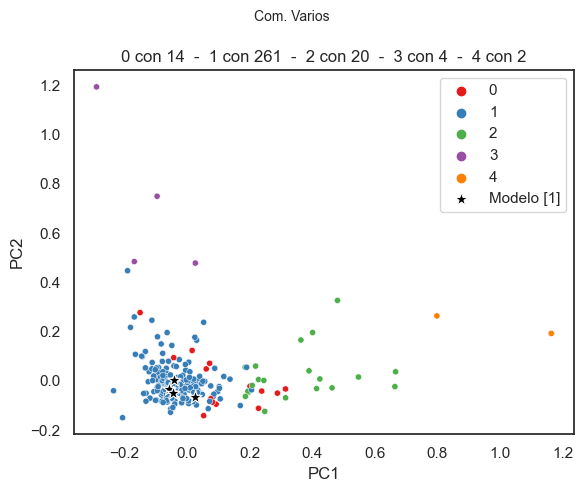

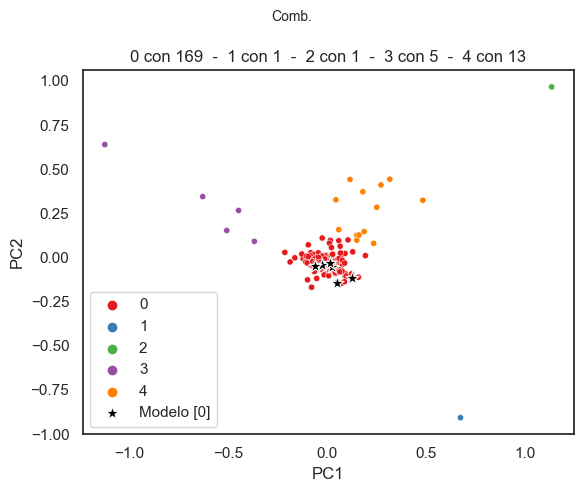

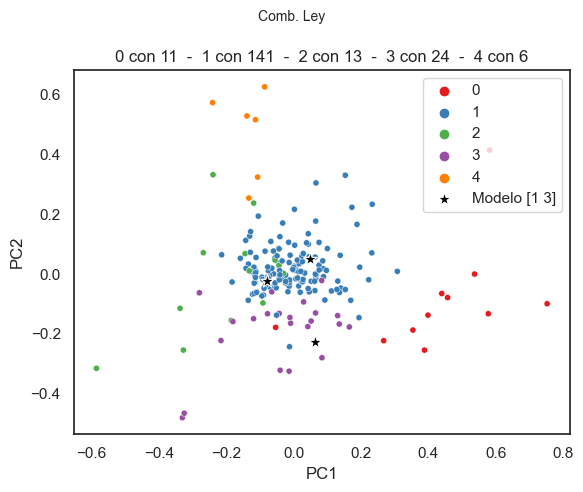

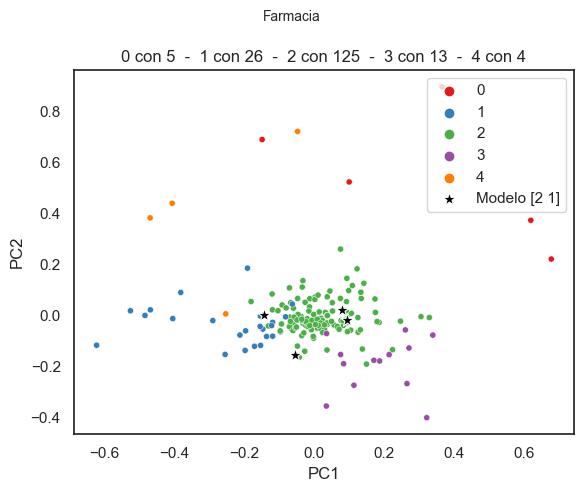

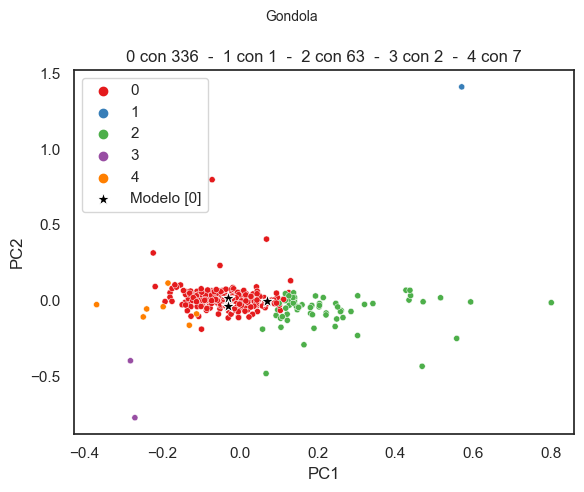

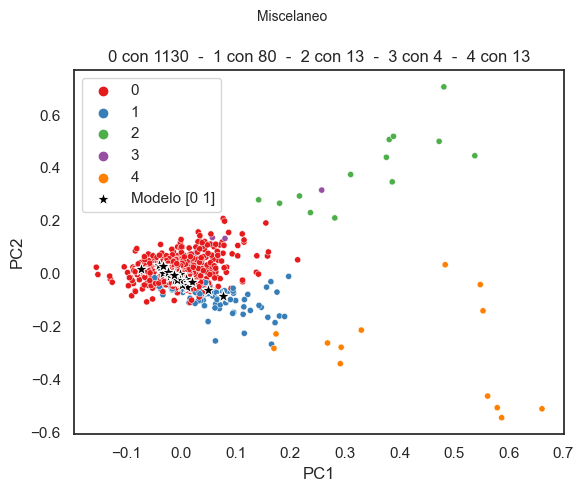

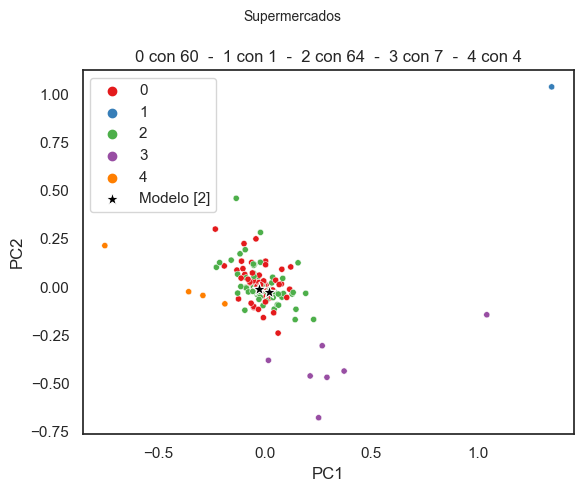

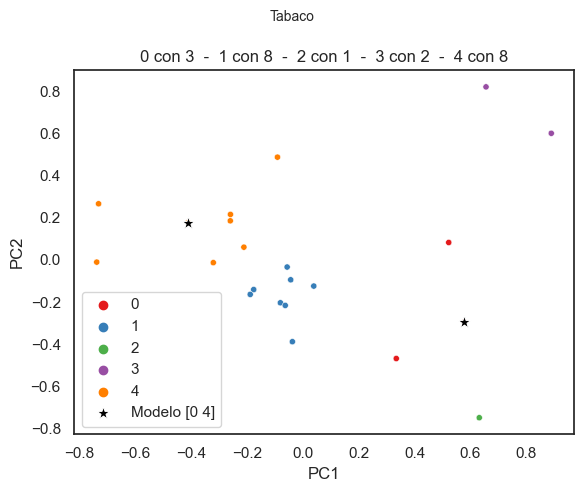

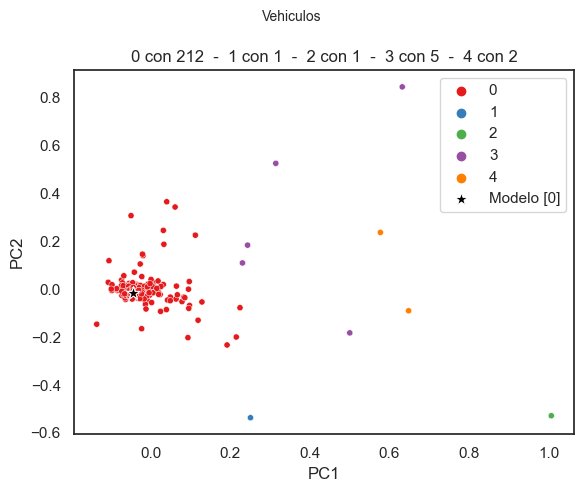

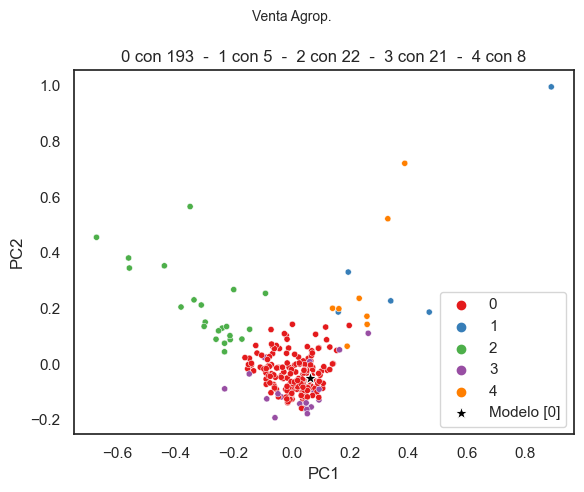

In [5]:
for sr in sr10_knn_pca.Subrubro.unique():
    # Dataset por subrubro
    categ = sr10_knn_pca[sr10_knn_pca['Subrubro'] == sr].iloc[:, :3].copy()
    categ.reset_index(inplace=True)
    tp3sr = sr10_knn_pca[sr10_knn_pca['Subrubro'] == sr].iloc[:, 3:].copy()

    # KMeans
    km = KMeans(n_clusters=5, n_init=10)
    km.fit_predict(tp3sr)
    clusters = km.labels_

    # PCA de 2 componentes para visualizar
    pca2 = PCA(n_components=2)
    subrubro_df_pca_2 = pca2.fit_transform(tp3sr)
    subrubro_df_clusters = pd.DataFrame(data=subrubro_df_pca_2, columns=[f'PC{i}' for i in range(1, 3)])
    subrubro_df_clusters['kmeans_n'] = km.labels_
    subrubro_df_clusters = pd.concat([categ, subrubro_df_clusters], axis=1)

    # Gráfico
    fig, axs = plt.subplots(figsize=(6, 5))
    fig.suptitle(f"{sr}", fontsize=10)
    sns.scatterplot(data=subrubro_df_clusters, x='PC1', y='PC2', hue='kmeans_n', palette='Set1', s=20, ax=axs)
    filt_modelo_1 = subrubro_df_clusters['Modelo'] == 1
    modclus = subrubro_df_clusters[filt_modelo_1]["kmeans_n"].unique()
    sns.scatterplot(data=subrubro_df_clusters[filt_modelo_1], x='PC1', y='PC2', color='black', s=100, label=f'Modelo {modclus}', ax=axs, marker='*')
    axs.legend()
    vc_clus = subrubro_df_clusters['kmeans_n'].value_counts()
    axs.set_title(f'0 con {vc_clus[0]}  -  1 con {vc_clus[1]}  -  2 con {vc_clus[2]}  -  3 con {vc_clus[3]}  -  4 con {vc_clus[4]}')

    plt.tight_layout()
    plt.show()

---
# Clustering con DBSCAN

Para definir el radio de búsqueda `eps` usamos el método de KNN propuesto por los autores de DBSCAN:
* [Sander et al. 1998](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.63.1629&rep=rep1&type=pdf)
* [Schubert et al. 2017](https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf)

En resumen la idea es la siguiente ([referencia](https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan)): si uno parte de datos con $N$ dimensiones, tenemos que elegir a $n_{neibours}$ en `sklearn.neighbors.NearestNeighbors` como un número igual a $2\times N-1$ y calcular las distancias de los $K$ vecinos más cercanos a cada punto del dataset. Luego, ordenamos las distancias y las graficamos para encontrar el *codo* donde se separan los puntos ruidosos (con las distancias $K$ más cercanos más altas) de los puntos con distancias de $K$ más cercanos relativamente bajas (que seguramente caigan dentro de algún cluster). 



## Determinación del `eps` óptimo
Aplicamos método del codo para definir el epsilon adecuado a cada subrurbo.

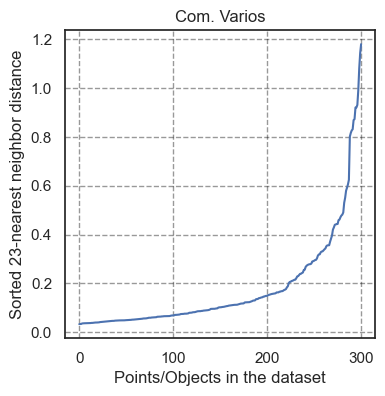

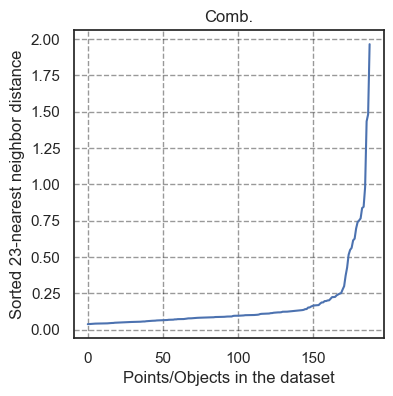

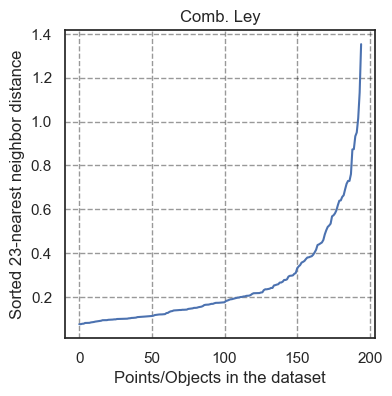

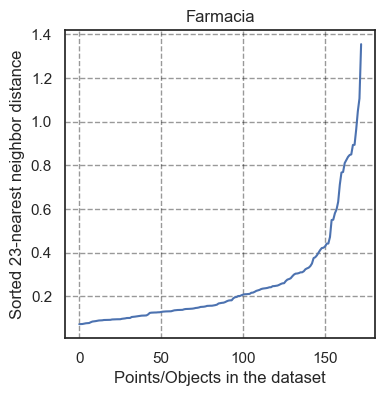

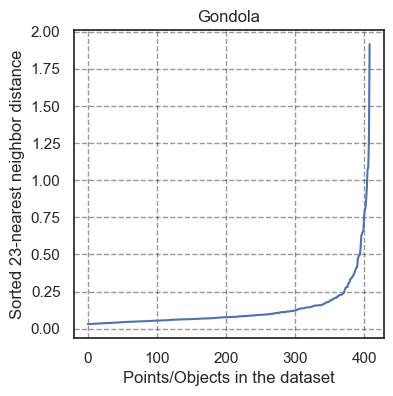

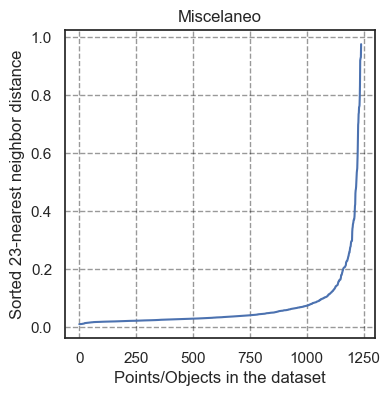

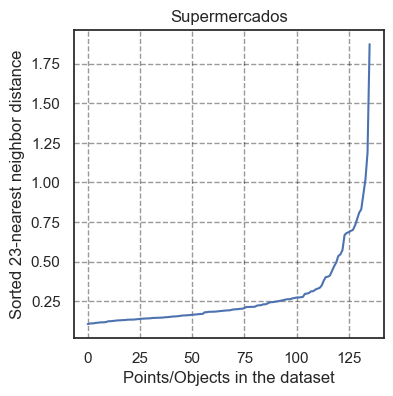

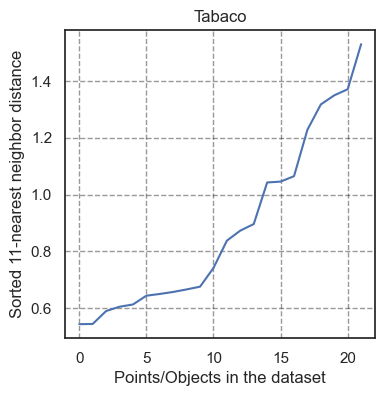

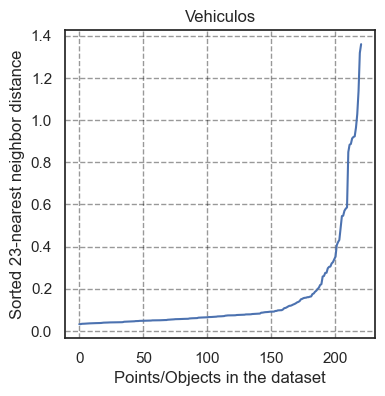

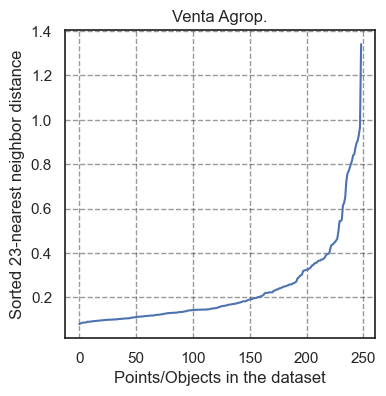

In [6]:
for sr in sr10_knn_pca.Subrubro.unique():
    
    # Dataset por subrubro
    categ = sr10_knn_pca[sr10_knn_pca['Subrubro'] == sr].iloc[:, :3].copy()
    categ.reset_index(inplace=True)
    tp3sr = sr10_knn_pca[sr10_knn_pca['Subrubro'] == sr].iloc[:, 3:].copy()

    k_ideal = 2 * tp3sr.shape[-1] - 1 # k=2*{dim(dataset)} - 1

    if tp3sr.shape[0] >= k_ideal:
        k = k_ideal
    else:
        k = int(tp3sr.shape[0]/2)

    nbrs = NearestNeighbors(n_neighbors=k, radius=1.0).fit(tp3sr)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(tp3sr) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    figsize_side = 4
    
    plt.figure(figsize=(figsize_side,figsize_side))
    plt.plot(distances)
    plt.title(sr)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


Creamos un diccionario con los epsilons más adecuados para cada subrubro.

In [7]:
subrubros = sr10_knn_pca.Subrubro.unique().tolist()
epsilons = [0.30, 0.25, 0.60, 0.40, 0.25, 0.15, 0.35, 0.70, 0.30, 0.40]

epsilons_dict = dict(zip(subrubros, epsilons))

print('Épsilons óptimos:')
for key in epsilons_dict:
    print('\t', key, "=", epsilons_dict[key])

Épsilons óptimos:
	 Com. Varios = 0.3
	 Comb. = 0.25
	 Comb. Ley = 0.6
	 Farmacia = 0.4
	 Gondola = 0.25
	 Miscelaneo = 0.15
	 Supermercados = 0.35
	 Tabaco = 0.7
	 Vehiculos = 0.3
	 Venta Agrop. = 0.4


## Clusterización con el `eps` óptimo para cada subrubro

epsilon: 0.3
min_samples: 23
Cantidad de clusters estimado: 1
Cantidad de puntos fuera de un cluster: 29
Cantidad de vendedores modelo: 4
 0    272
-1     29
Name: count, dtype: int64
[ 18  23  27  30  62 104 122 126 128 131 135 137 149 155 157 163 170 174
 184 196 213 220 221 238 249 268 275 291 295]


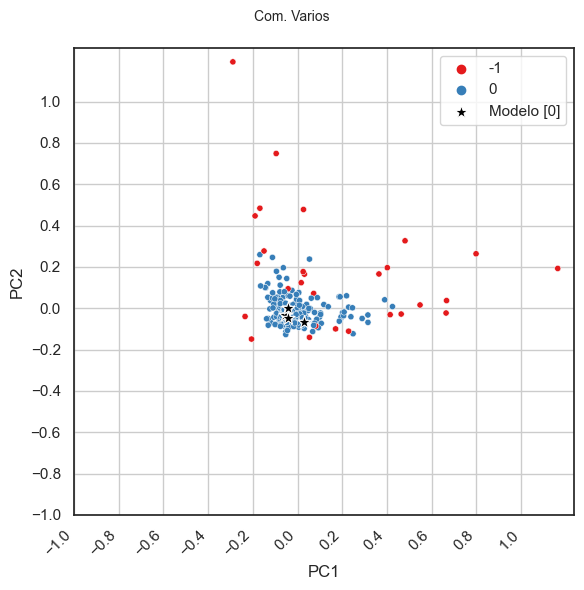

epsilon: 0.25
min_samples: 23
Cantidad de clusters estimado: 1
Cantidad de puntos fuera de un cluster: 15
Cantidad de vendedores modelo: 6
 0    174
-1     15
Name: count, dtype: int64
[  4   9  15  24  34  39  50  54 104 119 132 149 151 177 179]


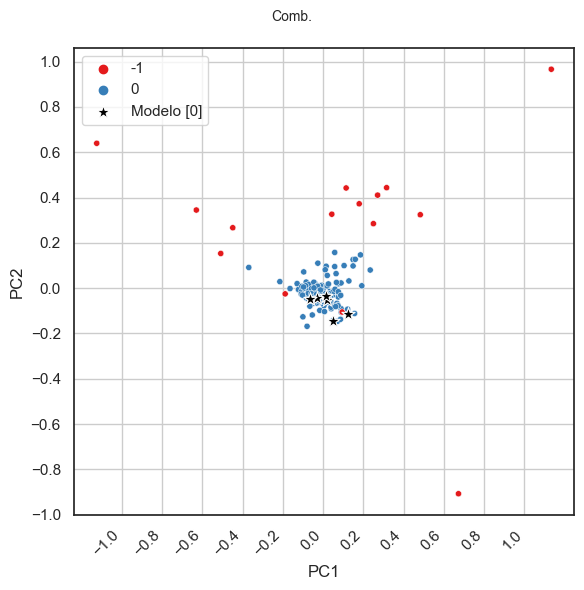

epsilon: 0.6
min_samples: 23
Cantidad de clusters estimado: 1
Cantidad de puntos fuera de un cluster: 5
Cantidad de vendedores modelo: 3
 0    190
-1      5
Name: count, dtype: int64
[ 32 106 136 161 169]


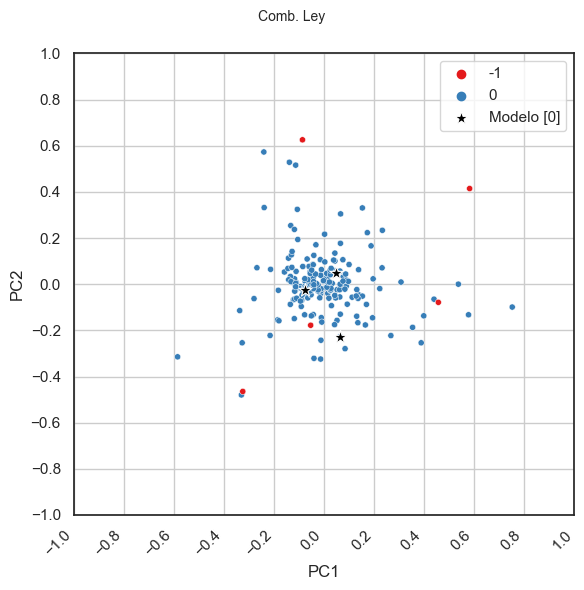

epsilon: 0.4
min_samples: 23
Cantidad de clusters estimado: 1
Cantidad de puntos fuera de un cluster: 16
Cantidad de vendedores modelo: 4
 0    157
-1     16
Name: count, dtype: int64
[ 10  39  44  47  55  69  74  78 113 116 118 121 124 126 128 129]


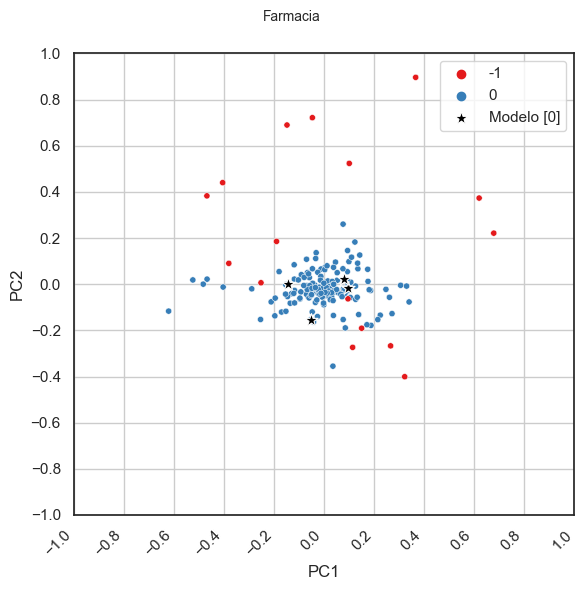

epsilon: 0.25
min_samples: 23
Cantidad de clusters estimado: 1
Cantidad de puntos fuera de un cluster: 22
Cantidad de vendedores modelo: 3
 0    387
-1     22
Name: count, dtype: int64
[ 25  31  36  38  48  70 109 187 220 221 223 245 261 309 328 331 341 367
 380 390 394 401]


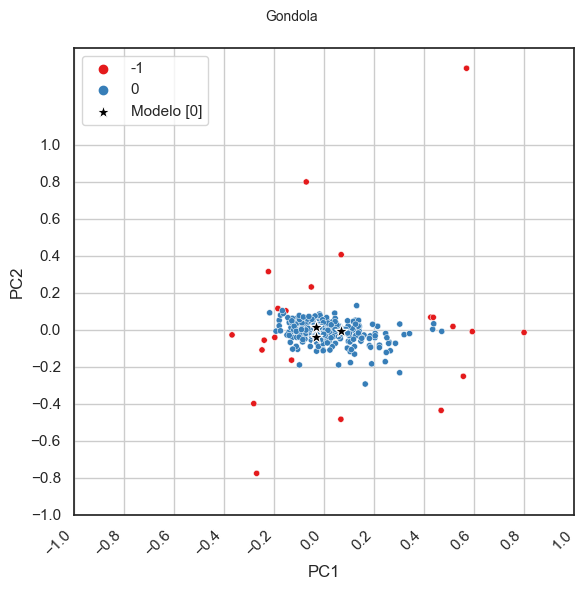

epsilon: 0.15
min_samples: 23
Cantidad de clusters estimado: 1
Cantidad de puntos fuera de un cluster: 70
Cantidad de vendedores modelo: 20
 0    1170
-1      70
Name: count, dtype: int64
[  15   85  113  119  130  142  182  185  196  222  242  259  284  286
  348  351  358  368  385  409  410  472  490  495  500  501  503  515
  522  539  543  544  598  621  628  645  679  756  774  776  778  786
  795  804  807  808  819  853  859  891  941  957  961  964 1026 1035
 1036 1048 1060 1072 1099 1107 1158 1161 1164 1184 1194 1207 1209 1217]


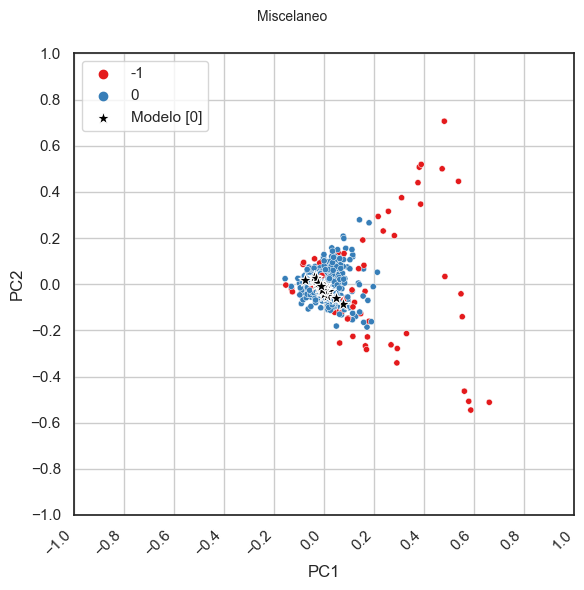

epsilon: 0.35
min_samples: 23
Cantidad de clusters estimado: 1
Cantidad de puntos fuera de un cluster: 18
Cantidad de vendedores modelo: 2
 0    118
-1     18
Name: count, dtype: int64
[  4   9  19  21  44  60  80  89  90  94 106 107 108 117 123 125 127 133]


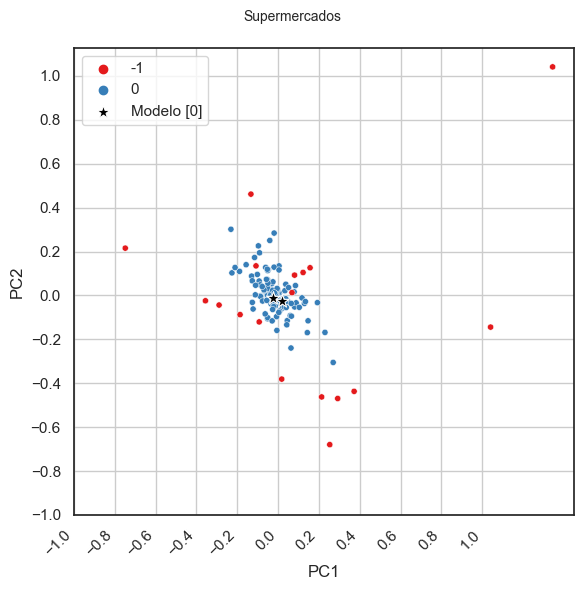

epsilon: 0.7
min_samples: 11
Cantidad de clusters estimado: 1
Cantidad de puntos fuera de un cluster: 7
Cantidad de vendedores modelo: 2
 0    15
-1     7
Name: count, dtype: int64
[ 5  7  9 11 14 17 19]


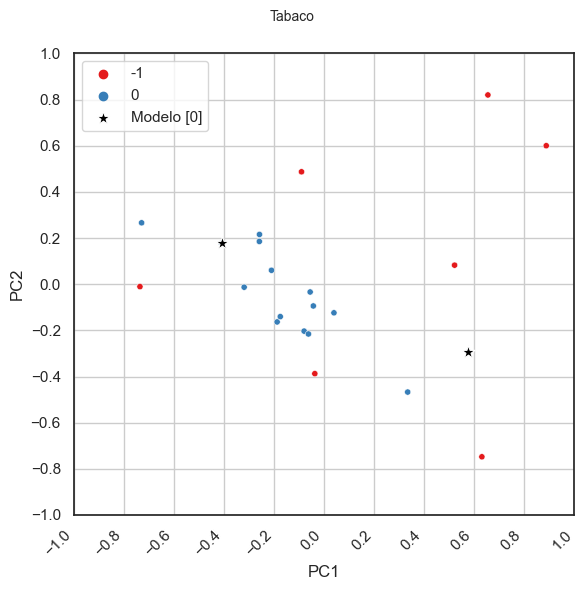

epsilon: 0.3
min_samples: 23
Cantidad de clusters estimado: 1
Cantidad de puntos fuera de un cluster: 18
Cantidad de vendedores modelo: 1
 0    203
-1     18
Name: count, dtype: int64
[ 10  13  25  40  67  71  94  95 103 105 154 165 173 182 185 198 204 214]


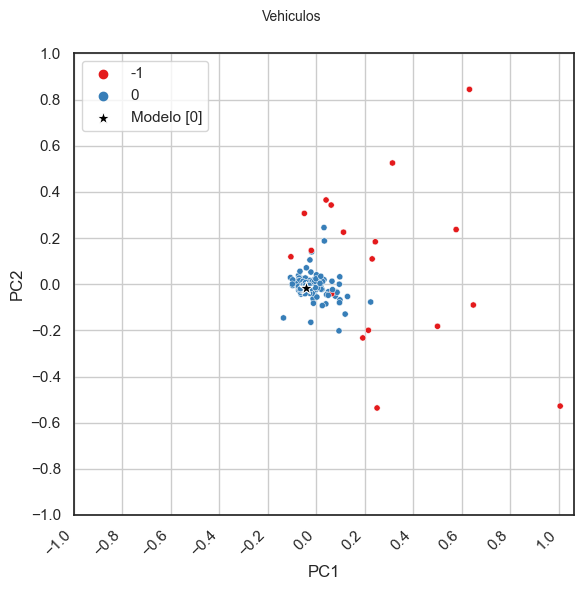

epsilon: 0.4
min_samples: 23
Cantidad de clusters estimado: 1
Cantidad de puntos fuera de un cluster: 17
Cantidad de vendedores modelo: 1
 0    232
-1     17
Name: count, dtype: int64
[ 34  41  54  66  69  70  87  94 103 112 136 163 167 220 223 227 228]


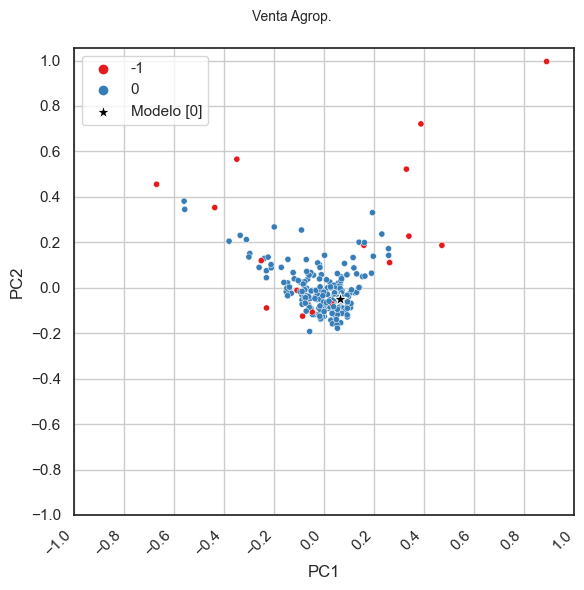

In [8]:
outliers_df_list = []

N_tot, N_mod, N_min, N_out, epsil = [], [], [], [], []

for sr in sr10_knn_pca.Subrubro.unique():
    # Dataset por subrubro
    categ = sr10_knn_pca[sr10_knn_pca['Subrubro'] == sr].iloc[:, :3].copy()
    categ.reset_index(inplace=True)
    tp3sr = sr10_knn_pca[sr10_knn_pca['Subrubro'] == sr].iloc[:, 3:].copy()

    # DBSCAN
    #min_samples_ideal = 2 * tp3sr.shape[-1] - 1 # k=2*{dim(dataset)} - 1
    min_samples_ideal = 2 * tp3sr.shape[1] - 1

    if tp3sr.shape[0] >= min_samples_ideal:
        min_samples = min_samples_ideal
    else:
        min_samples = int(tp3sr.shape[0]/2)

    dbscan = DBSCAN(eps=epsilons_dict[sr], min_samples=min_samples)
    dbscan.fit(tp3sr)
    epsil.append(epsilons_dict[sr])

    labels = dbscan.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    print(f"epsilon: {epsilons_dict[sr]}")
    print(f"min_samples: {min_samples}")
    N_min.append(min_samples)

    print("Cantidad de clusters estimado: %d" % n_clusters_)
    print("Cantidad de puntos fuera de un cluster: %d" % n_noise_)
    N_out.append(n_noise_)
    print("Cantidad de vendedores modelo: %d" % categ['Modelo'].sum())
    N_mod.append(categ['Modelo'].sum())
    N_tot.append(len(categ['Modelo']))

    print(pd.DataFrame(dbscan.labels_).value_counts())
    
    print(np.where(dbscan.labels_ == -1)[0])
    
    ### agregar dataframe
    idx_outliers = np.where(dbscan.labels_ == -1)[0]
    #sr10_knn_pca_subrubro = sr10_knn_pca[sr10_knn_pca['Subrubro'] == sr].copy()
    #sr10_knn_pca_subrubro = sr10_knn_pca_subrubro.reset_index().drop(["index"], axis=1)
    
    #df_outliers_loop = sr10_knn_pca_subrubro[sr10_knn_pca_subrubro.index.isin(idx_outliers)]
    df_outliers_loop = categ[categ.index.isin(idx_outliers)]
    
    outliers_df_list.append(df_outliers_loop)
    
    #df_outliers = pd.concat([df_outliers, df_outliers_loop], ignore_index=False)
    #print(f"longitud de df_outliers: {df_outliers.shape[0]}")

    # PCA de 2 componentes para visualizar
    pca2 = PCA(n_components=2)
    subrubro_df_pca_2 = pca2.fit_transform(tp3sr)
    subrubro_df_clusters = pd.DataFrame(data=subrubro_df_pca_2, columns=[f'PC{i}' for i in range(1, 3)])
    subrubro_df_clusters['dbscan_labels'] = dbscan.labels_
    subrubro_df_clusters = pd.concat([categ, subrubro_df_clusters], axis=1)

    # Gráfico
    
    x = [i * 0.2 for i in range(-5, 6)]  # Values from 0.0 to 1.0 with a step of 0.1
    y = [i * 0.2 for i in range(-5, 6)]  # Values from 0.0 to 1.0 with a step of 0.1

    
    fig, axs = plt.subplots(figsize=(6, 6))
    fig.suptitle(f"{sr}", fontsize=10)
    sns.scatterplot(data=subrubro_df_clusters, x='PC1', y='PC2', hue='dbscan_labels', palette='Set1', s=20, ax=axs)
    filt_modelo_1 = subrubro_df_clusters['Modelo'] == 1
    modclus = subrubro_df_clusters[filt_modelo_1]["dbscan_labels"].unique()
    sns.scatterplot(data=subrubro_df_clusters[filt_modelo_1], x='PC1', y='PC2', color='black', s=100, label=f'Modelo {modclus}', ax=axs, marker='*')
    axs.legend()
    
    # Add a grid with gridlines every 0.1 units in both axes
    axs.set_xticks(x)
    axs.set_yticks(y)
    axs.grid(which='both')

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    # plt.savefig(f'../reports/figures/tp3_dbscan_{sr}.png')
    plt.show()
    
df_outliers = pd.concat(outliers_df_list, ignore_index=True)
df_outliers = df_outliers.reset_index(drop=True).drop(["index"], axis=1)


In [9]:
df_outliers

,ID,Subrubro,Modelo
0,141,Com. Varios,0
1,233,Com. Varios,0
2,324,Com. Varios,0
3,373,Com. Varios,0
4,735,Com. Varios,0
...,...,...,...
212,2147,Venta Agrop.,0
213,2605,Venta Agrop.,0
214,2661,Venta Agrop.,0
215,2716,Venta Agrop.,0


In [10]:
df_outliers.to_csv("../data/interim/tp3_outliers_dbscan.csv", index=False)

In [11]:
N_tot = np.array(N_tot)
N_mod = np.array(N_mod)
epsil = np.array(epsil)
N_min = np.array(N_min)
N_out = np.array(N_out)

arr = np.array([N_tot, N_mod, 100*N_mod/N_tot, epsil, N_min, N_out, 100*N_out/N_tot])

results = pd.DataFrame(arr.T, index=sr10_knn_pca.Subrubro.unique(),
                       columns=['N_tot', 'N_mod', 'R_mod', 'epsil', 'N_min', 'N_out', 'R_out'])
results.round(2)

,N_tot,N_mod,R_mod,epsil,N_min,N_out,R_out
Com. Varios,301.0,4.0,1.33,0.30,23.0,29.0,9.63
Comb.,189.0,6.0,3.17,0.25,23.0,15.0,7.94
Comb. Ley,195.0,3.0,1.54,0.60,23.0,5.0,2.56
Farmacia,173.0,4.0,2.31,0.40,23.0,16.0,9.25
Gondola,409.0,3.0,0.73,0.25,23.0,22.0,5.38
Miscelaneo,1240.0,20.0,1.61,0.15,23.0,70.0,5.65
Supermercados,136.0,2.0,1.47,0.35,23.0,18.0,13.24
Tabaco,22.0,2.0,9.09,0.70,11.0,7.0,31.82
Vehiculos,221.0,1.0,0.45,0.30,23.0,18.0,8.14
Venta Agrop.,249.0,1.0,0.40,0.40,23.0,17.0,6.83


In [13]:
results[['N_tot', 'N_mod', 'N_out']].sum()

N_tot    3135.0
N_mod      46.0
N_out     217.0
dtype: float64

In [14]:
print(f'Hay {100*46/3135:.2f} % de modelos en total.')
print(f'Hay {100*217/3135:.2f} % de outliers en total.')

Hay 1.47 % de modelos en total.
Hay 6.92 % de outliers en total.
